In [1]:
import numpy as np
from mpmath import nsum, nprod, fac
from statistics import mean
import matplotlib.pyplot as plt
import math
import random

# Моделирование системы массового обслуживания

### Вариант 15

Рассматривается простейшая двухканальная СМО с «нетерпеливыми» заявками . Интенсивность потока заявок $X = 3$ заявки/ч; среднее время обслуживания одной заявки $t_{обс} = 1/\mu = 1 ч$; средний срок, в течение которого заявка «терпеливо» стоит в очереди, равен $0,5 ч$. Подсчитать финальные вероятности состояний, ограничиваясь теми, которые не меньше $0,001$. Найти характеристики эффективности СМО: абсолютную и относительную пропускные способности системы, среднее время пребывания заявки в системе, среднюю длину очереди.

### Граф состояний системы

![Граф состояний системы](https://i.imgur.com/nQ7GP25.png)

### Вычисление вероятности $p_0$
$ \rho = \lambda / \mu $

$ \beta = \nu / \mu $

![](https://i.imgur.com/ji76ki9.png)

![](https://i.imgur.com/t7ZqK8S.png)

Имеем $ \lambda = 3, \mu = 1, \nu = 2, \rho = 3, \beta = 2, n = 2 $

![](https://i.imgur.com/T5wLBs1.png)

### Вычисление остальных финальных вероятностей состояний $p_1 - p_8$

![](https://i.imgur.com/Mk3l1bX.png)

![](https://i.imgur.com/GW3Vczz.png)

## Реализация модели системы массового обслуживания

Предложенная система является простейшей, т.е. интервалы времени между событиями в потоках имеют показательное распределение с параметром, равным интенсивности соответствующего потока.

Для имитации простейших потоков событий воспользуемся следующей функцией:

In [2]:
def generate(param):
    while True:
        yield -math.log(random.random()) / param



В описанной системе существует 3 вида событий, изменяющих состояние системы: 
* появление заявки,
* конец обработки заявки,
* выход заявки из очереди.

При моделировании эти события будут расположены на временной прямой для последовательной обработки программой симуляции.

In [3]:
class QueryArrived:
    def __init__(self, timepoint):
        self.timepoint = timepoint

    def __str__(self):
        return self.timepoint


class QueryProcessed:
    def __init__(self, start_timepoint, timepoint, channel):
        self.start_timepoint = start_timepoint
        self.timepoint = timepoint
        self.channel = channel

    def __str__(self):
        return self.timepoint


class QueryDropped:
    def __init__(self, arrive_timepoint, deadline_timepoint):
        self.arrive_timepoint = arrive_timepoint
        self.timepoint = deadline_timepoint

    def __str__(self):
        return self.timepoint

### Модель

In [4]:
class Model:
    def __init__(self, n, lambd, apt, awt, queries):
        random.seed()
        self.n = n
        self.m = 10
        self.lambd = lambd
        self.mu = 1 / apt
        self.nu = 1 / awt
        self.queries = queries

        self.channel_availabilities = [True] * n
        self.timeline = []
        self.queue = []

        self.busy_channels = 0

        self.state_durations = []
        self.final_state_durations = [0] * (n + self.m + 1)
        self.last_state = 0
        self.last_state_change_timepoint = 0

        self.queries_processed = 0
        self.queries_dropped = 0

        self.processing_time = []
        self.waiting_time = []

    def start(self):
        query_gen = self.generate(self.lambd)
        processing_gen = self.generate(self.mu)
        waiting_gen = self.generate(self.nu)

        first_timepoint = next(query_gen)
        self.timeline.append(QueryArrived(first_timepoint))

        for _ in range(self.queries - 1):
            timepoint = self.timeline[-1].timepoint + next(query_gen)
            self.timeline.append(QueryArrived(timepoint))

        for event in self.timeline:
            if isinstance(event, QueryArrived):
                has_available_channels, channel = self.find_channel()

                if has_available_channels:
                    query_processed_timepoint = event.timepoint + next(processing_gen)
                    query_processed_event = QueryProcessed(event.timepoint, query_processed_timepoint, channel)
                    self.insert(query_processed_event)
                    self.record_state(event.timepoint)
                    self.waiting_time.append(0)
                else:
                    waiting_deadline = event.timepoint + next(waiting_gen)
                    self.insert(QueryDropped(event.timepoint, waiting_deadline))
                    self.queue.append(event.timepoint)
                    self.record_state(event.timepoint)

            if isinstance(event, QueryProcessed):
                self.queries_processed += 1
                self.busy_channels -= 1
                self.channel_availabilities[event.channel] = True
                self.processing_time.append(event.timepoint - event.start_timepoint)

                if len(self.queue) != 0:
                    start_timepoint = self.queue.pop(0)

                    query_processed_timepoint = event.timepoint + next(processing_gen)
                    query_processed_event = QueryProcessed(event.timepoint, query_processed_timepoint,
                                                           event.channel)
                    self.channel_availabilities[event.channel] = False
                    self.busy_channels += 1
                    self.insert(query_processed_event)
                    self.waiting_time.append(event.timepoint - start_timepoint)

                self.record_state(event.timepoint)

            if isinstance(event, QueryDropped):
                query = [x for x in self.queue if x == event.arrive_timepoint]
                if query:
                    self.queries_dropped += 1
                    self.queue = [x for x in self.queue if x != event.arrive_timepoint]
                    self.record_state(event.timepoint)

    @staticmethod
    def generate(param):
        while True:
            yield -math.log(random.random()) / param

    def insert(self, event):
        for i in range(1, len(self.timeline)):
            if self.timeline[i - 1].timepoint < event.timepoint < self.timeline[i].timepoint:
                self.timeline.insert(i, event)
                break
        else:
            self.timeline.append(event)

    def find_channel(self):
        for i, status in enumerate(self.channel_availabilities):
            if status:
                self.busy_channels += 1
                self.channel_availabilities[i] = False

                return True, i

        return False, -1

    def record_state(self, timepoint):
        time_delta = timepoint - self.last_state_change_timepoint
        self.final_state_durations[self.last_state] += time_delta

        self.last_state_change_timepoint = timepoint
        self.last_state = self.busy_channels + len(self.queue)

        self.state_durations.append((timepoint, self.final_state_durations.copy()))

    def show_empirical_stats(self):
        print('EMPIRICAL STATS')
        print('Queries processed:', self.queries_processed)
        print('Queries dropped:', self.queries_dropped)

        avg_processing = 0
        probs = []
        for k in range(self.n + 1):
            pk = self.final_state_durations[k] / self.timeline[-1].timepoint
            probs.append(pk)
            avg_processing += k * pk
            print(f'{k} channels are busy & 0 queries in queue | p{k} =', pk)

        avg_queue_length = 0
        s = self.n + 1
        while True:
            ps = self.final_state_durations[s] / self.timeline[-1].timepoint
            if ps < 0.001:
                break
            probs.append(ps)
            avg_queue_length += (s - self.n) * ps
            print(f'{self.n} channels are busy & {s - self.n} queries in queue | p{self.n}+{s - self.n} =', ps)
            s += 1

        p_denial = self.queries_dropped / self.queries
        Q = 1 - p_denial
        A = self.lambd * Q
        avg_waiting_time = mean(self.waiting_time)
        avg_processing_time = mean(self.processing_time)
        avg_total_time = avg_waiting_time + avg_processing_time
        print('Relative throughput: ', Q)
        print('Absolute throughput: ', A)
        print('Average queue length: ', avg_queue_length)
        print('Average time in system: ', avg_total_time)

        return probs

    def show_theoretical_stats(self):
        print('THEORETICAL STATS')
        ro = self.lambd / self.mu
        p0 = 1 / (nsum(lambda k: ro ** k / fac(k), [0, self.n]) + (ro ** self.n / fac(self.n)) * nsum(
            lambda i: self.lambd ** i / nprod(lambda l: (self.n * self.mu + l * self.nu), [1, i]), [1, self.m]))
        print('0 channels are busy & 0 queries in queue | p0 =', p0)

        avg_processing = 0
        probs = [p0]
        for k in range(1, self.n + 1):
            pk = ro ** k * p0 / fac(k)
            probs.append(pk)
            avg_processing += k * pk
            print(f'{k} channels are busy & 0 queries in queue | p{k} =', pk)

        avg_queue_length = 0
        s = 1
        while True:
            ps = (ro ** self.n) * (self.lambd ** s) * p0 / (fac(self.n) * nprod(lambda l: self.n * self.mu + l * self.nu, [1, s]))
            if ps < 0.001:
                break
            probs.append(ps)
            avg_queue_length += s * ps
            print(f'{self.n} channels are busy & {s} queries in queue | p{self.n}+{s} =', ps)
            s += 1

        p_denial = 1 - (self.nu / self.lambd) * avg_processing
        Q = 1 - p_denial
        A = self.lambd * Q
        avg_waiting_time = avg_queue_length / self.lambd
        avg_processing_time = 1 / self.mu
        avg_total_time = avg_processing_time + avg_waiting_time
        print('Relative throughput: ', Q)
        print('Absolute throughput: ', A)
        print('Average queue length: ', avg_queue_length)
        print('Average time in system: ', avg_total_time)
        return probs

    def show_stats(self):
        e_probs = model.show_empirical_stats()
        print()
        t_probs = model.show_theoretical_stats()

        _, ax = plt.subplots(1, 2)
        ax[0].title.set_text(
            f'Empirical probabilities')
        ax[0].bar(list(np.arange(0, len(e_probs))), e_probs)
        ax[1].title.set_text(
            f'Theoretical probabilities')
        ax[1].bar(list(np.arange(0, len(t_probs))), t_probs)
        plt.show()

EMPIRICAL STATS
Queries processed: 571
Queries dropped: 429
0 channels are busy & 0 queries in queue | p0 = 0.06944186633990117
1 channels are busy & 0 queries in queue | p1 = 0.20435792248720325
2 channels are busy & 0 queries in queue | p2 = 0.2978737736053032
2 channels are busy & 1 queries in queue | p2+1 = 0.24448753976260382
2 channels are busy & 2 queries in queue | p2+2 = 0.12415441168384948
2 channels are busy & 3 queries in queue | p2+3 = 0.041165639293813804
2 channels are busy & 4 queries in queue | p2+4 = 0.01598733967057957
2 channels are busy & 5 queries in queue | p2+5 = 0.0019801145593071707
Relative throughput:  0.571
Absolute throughput:  1.7129999999999999
Average queue length:  0.6901432124905984
Average time in system:  1.158631034672051

THEORETICAL STATS
0 channels are busy & 0 queries in queue | p0 = 0.0692277888991365
1 channels are busy & 0 queries in queue | p1 = 0.20768336669741
2 channels are busy & 0 queries in queue | p2 = 0.311525050046114
2 channels ar

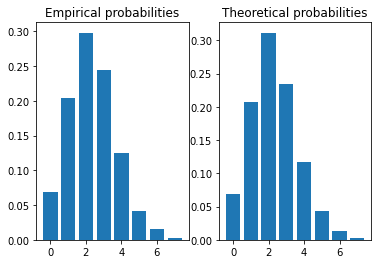

In [5]:
channels = 2
income_intensivity = 3
processing_time = 1
waiting_time = 0.5
N = 1000

model = Model(channels, income_intensivity, processing_time, waiting_time, N)
model.start()
model.show_stats()